In [1]:
import os
os.chdir("..")

In [2]:
from utils.data_utils import ImageDataset
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
import torch

## Load Dataset

In [3]:
# load data file
data_file= "datasets/faf_dataset_cleaned.csv"
filenames_col= "file.path"
labels_col= "gene"
train_classes= "classes.txt"

# create transformations
image_transforms = []
resize_dim = 512
image_transforms.append(transforms.Resize((resize_dim, resize_dim)))
image_transforms.append(transforms.Grayscale())
image_transforms.append(transforms.ToTensor())
# image_transforms.append(transforms.Normalize((0.5,), (0.5,)))
image_transforms = transforms.Compose(image_transforms)

# load dataset
dataset = ImageDataset(data_file, filenames_col, labels_col, ["ABCA4"], image_transforms)

In [21]:
img = np.array([dataset[i][2].numpy().squeeze() for i in range(10)])

from utils.vesselsegmentor.blood_segmentation.generator import RetinalBloodVesselGenerator as segmentor
seg = segmentor(net_type="unet", pretrained_model="utils/vesselsegmentor/models/unet.pth", using_gpu=False)
im_filtered = Image.fromarray(img)
# thresholding_map = seg.generate(im_filtered.convert(mode="RGB"))

(10, 512, 512)


TypeError: Cannot handle this data type: (1, 1, 512), <f4

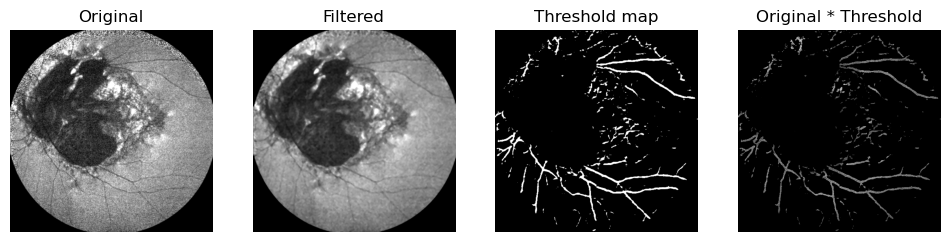

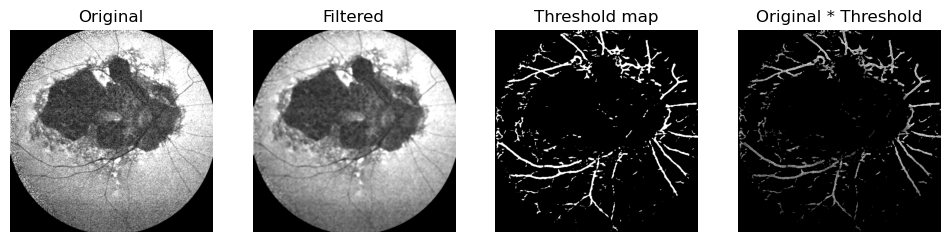

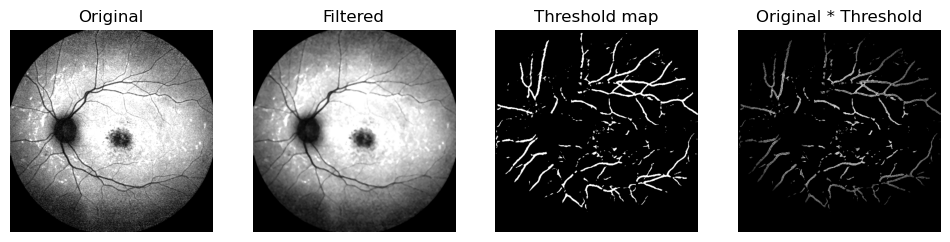

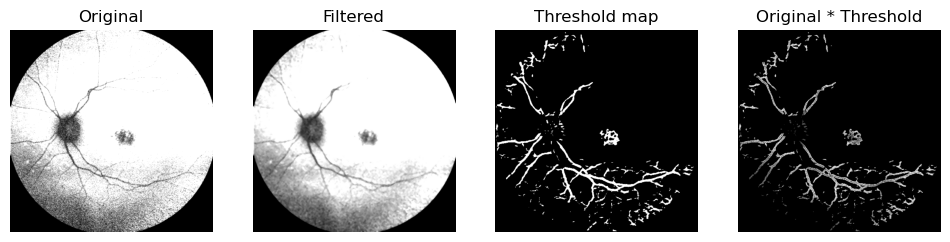

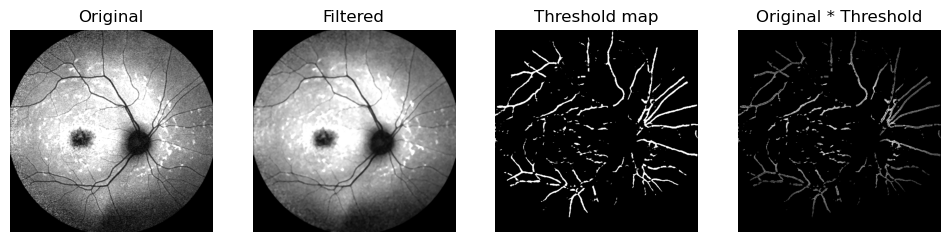

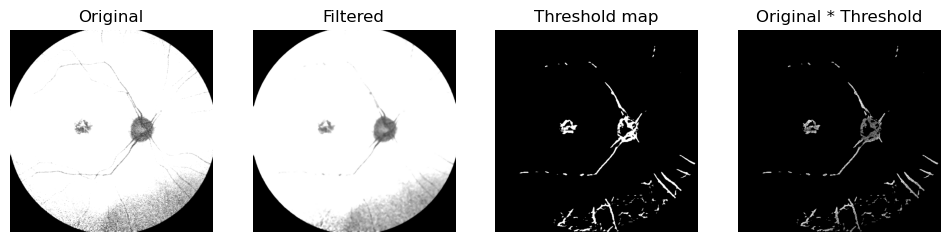

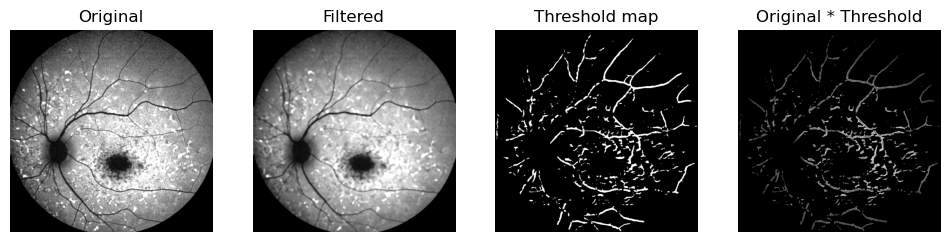

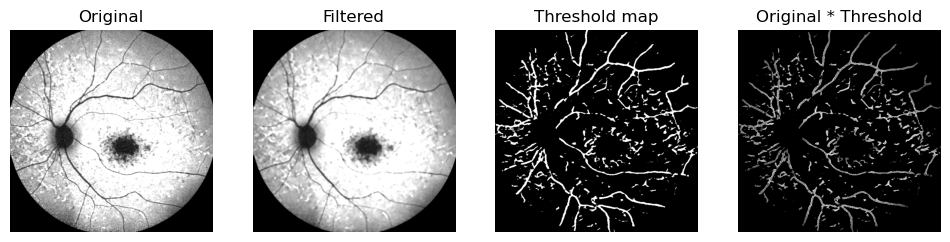

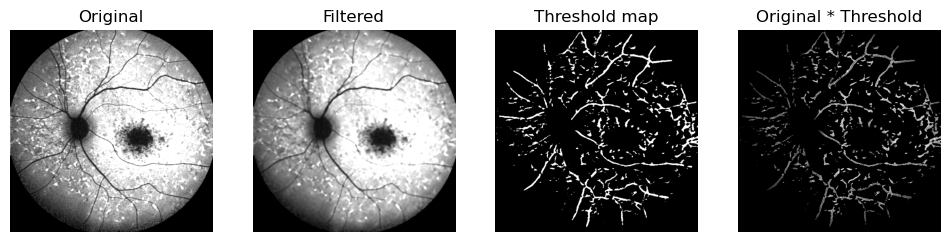

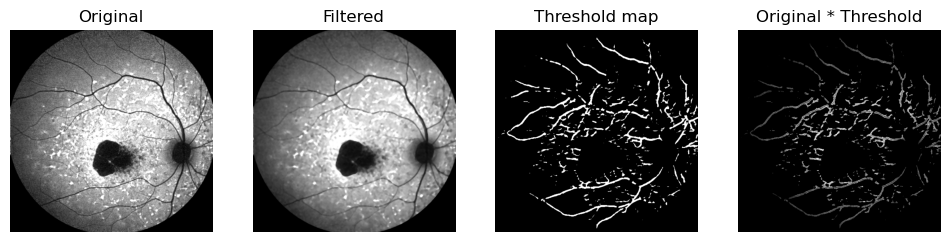

In [18]:
alpha = 3.0
beta = 0.0
filter_type = "median"
thresholding = "segment"

img = [dataset[i][2].numpy().squeeze() for i in range(10)]
 
for im in img:    
    # process image
    im = np.uint8(im * 255)
    im = np.clip(alpha*im + beta, 0, 255)
    
    # apply filter
    if filter_type == "averaging":
        im_filtered = cv2.blur(im, (7, 7))
    elif filter_type == "gaussian":
        im_filtered = cv2.GaussianBlur(im, (7,7), 0)
    elif filter_type == "median":
        im_filtered = cv2.medianBlur(np.float32(im), 5, (5, 5))
    else:
        im_filtered = im
    
    # apply thresholding
    if thresholding == "global":
        ret, thresholding_map = cv2.threshold(im_filtered, 50, 1, cv2.THRESH_BINARY_INV)
    elif thresholding == "segment":
        from utils.vesselsegmentor.blood_segmentation.generator import RetinalBloodVesselGenerator as segmentor
        seg = segmentor(net_type="unet", pretrained_model="utils/vesselsegmentor/models/unet.pth", using_gpu=False)
        im_filtered = Image.fromarray(im_filtered)
        thresholding_map = seg.generate(im_filtered.convert(mode="RGB"))
    else:
        thresholding_map = cv2.adaptiveThreshold(im_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(im, plt.cm.gray)
    plt.axis("off"), plt.title("Original")
    
    plt.subplot(1, 4, 2)
    plt.imshow(im_filtered, plt.cm.gray)
    plt.axis("off"), plt.title("Filtered")
    
    plt.subplot(1, 4, 3)
    plt.imshow(thresholding_map, plt.cm.gray)
    plt.axis("off"), plt.title("Threshold map")
    
    plt.subplot(1, 4, 4)
    plt.imshow(thresholding_map*im, plt.cm.gray)
    plt.axis("off"), plt.title("Original * Threshold")
    
    plt.show()